In [77]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from Utils.Gas_Storage_Env import GasStorageEnv
import numpy as np
import os
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, DDPG, TD3, A2C, SAC, DQN
from Train import run_test
from Utils.Plots import plot_sigma_robustness,plot_sigma_robustness_single

import pandas as pd

# **ASSESSING ROBUSTNESS FOR DIFFERENT SIGMAS**

In [78]:
# 1) Test sigma values
sigma_s = [0.035, 0.04, 0.045, 0.05, 0.055, 0.06,0.065,0.07]

# 2) Metrics
ep_metric_keys = [
 "bank account",  "market","price", "november inventory"
]

# 3) Episodes and steps
n_episodes     = 200
max_test_steps = 360

## *BASELINE MODEL (NO PENALTY TRESHOLD)*

In [79]:
 #load model 
model = SAC.load("/home/tizianobacaloni/GasRL/Models/sac_model_1500000_pen1000.0_pen_thresh0.0_rep4/sac_model_1500000_pen1000.0_pen_thresh0.0_rep4.zip")
import os
print("Working dir:", os.getcwd())


Working dir: /home/tizianobacaloni/GasRL/Plots


In [ ]:
cumulative = [ "market","bank account"]
# 1) Accumulators
sigma_vals = []
means_dict = {k: [] for k in ep_metric_keys}
cis_dict   = {k: [] for k in ep_metric_keys}

# 2) For each sigma, compute the mean of each metric  
for sigma in sigma_s:
    tmp_mean, tmp_ci, _, _ = run_test(model, n_episodes, max_test_steps, ep_metric_keys, sigma=sigma)
    sigma_vals.append(sigma)
    
    for key in ep_metric_keys:
        if key in  cumulative:
            means_dict[key].append(((tmp_mean[key])[0][-1]))  # Each key of the dict is a 2-element list: 1st is an array of length  max_test_step in which each value is the mean across  n_reps repetitions for that step
            cis_dict[key].append(((tmp_ci[key][0][-1])))      # Since these variables are cumulative,  only take the last element of the list
                                                              # Taking[0] alows to acess 1st element of the list, which is the array above
        else:  #####MEAN OF THE MEAN ACROSS REPETITION
            means_dict[key].append(np.nanmean(tmp_mean[key])) # Computing mean over the array of lenght max_test_step instead taking the last element
            cis_dict[key].append(np.nanmean(tmp_ci[key]))     

# 3) Sving folder
save_root = "Sigma_without_pen_thresh"
os.makedirs(save_root, exist_ok=True)

# 4) Database  to be saved for faster plotting
np.save(os.path.join(save_root, "means_dict.npy"), means_dict)
np.save(os.path.join(save_root, "cis_dict.npy"),   cis_dict)



In [ ]:
means_dict = np.load("Sigma_without_pen_thresh/means_dict.npy", allow_pickle=True)
cis_dict = np.load("Sigma_without_pen_thresh/cis_dict.npy", allow_pickle=True)

## *MODEL WITH PENALTY TRESHOLD*

In [ ]:
model = SAC.load("/home/tizianobacaloni/GasRL/Models/sac_model_1500000_pen1000.0_pen_thresh1000.0_rep1/sac_model_1500000_pen1000.0_pen_thresh1000.0_rep1.zip")

In [ ]:
cumulative = [ "market","bank account"]
# 1) Accumulators
sigma_vals = []
means_dict = {k: [] for k in ep_metric_keys}
cis_dict   = {k: [] for k in ep_metric_keys}

# 2) For each sigma,compute the mean of each metric
for sigma in sigma_s:
    tmp_mean, tmp_ci, _, _ = run_test(model, n_episodes, max_test_steps, ep_metric_keys, sigma=sigma)
    sigma_vals.append(sigma)
    
    for key in ep_metric_keys:
        if key in  cumulative:
            means_dict[key].append(((tmp_mean[key])[0][-1]))  # Each key of the dict is a 2-element list: 1st is an array of length  max_test_step in which each value is the mean across  n_reps repetitions for that step
            cis_dict[key].append(((tmp_ci[key][0][-1])))      # Since these variables are cumulative,  only take the last element of the list
                                                              # Taking[0] alows to acess 1st element of the list, which is the array above
        else:
            means_dict[key].append(np.nanmean(tmp_mean[key])) # Computing mean over the array of lenght max_test_step instead taking the last element
            cis_dict[key].append(np.nanmean(tmp_ci[key]))     

# 3) Saving folder
save_root = "Sigma_pen_thresh"
os.makedirs(save_root, exist_ok=True)

# 4) Database to be saved for faster plotting
np.save(os.path.join(save_root, "means_dict.npy"), means_dict)
np.save(os.path.join(save_root, "cis_dict.npy"),   cis_dict)
 

Test completed with 2 repetitions


Test completed with 2 repetitions
Test completed with 2 repetitions
Test completed with 2 repetitions
Test completed with 2 repetitions
Test completed with 2 repetitions
Test completed with 2 repetitions
Test completed with 2 repetitions


In [ ]:
means_dict = np.load("Sigma_pen_thresh/means_dict.npy", allow_pickle=True)
cis_dict = np.load("Sigma_pen_thresh/cis_dict.npy", allow_pickle=True)

In [ ]:
FIGSIZE=(3,3)

## ***ROBUSTNESS COMPARISON***


##### *Price values are defined as: mean of price series, with lenght=max_test_step, in which each value t is the mean across n_reps*

In [ ]:
# Loading data for both models and selecting just keys of interest
means_dict_1 = np.load("Sigma_without_pen_thresh/means_dict.npy", allow_pickle=True).item()
means_dict_2 = np.load("Sigma_pen_thresh/means_dict.npy", allow_pickle=True).item()
cis_dict_1 = np.load("Sigma_without_pen_thresh/cis_dict.npy", allow_pickle=True).item()
cis_dict_2 = np.load("Sigma_pen_thresh/cis_dict.npy", allow_pickle=True).item()


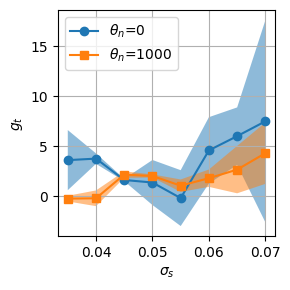

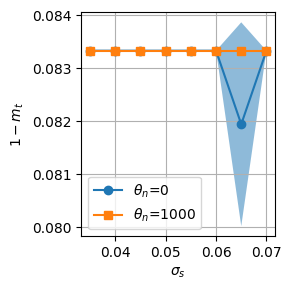

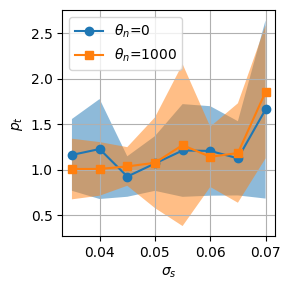

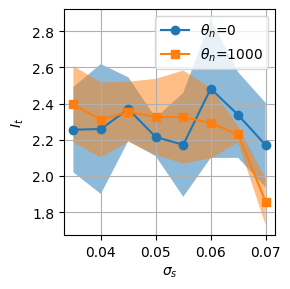

In [ ]:

#Plotting the metrics for both models
for key in means_dict_1.keys():
    metric_data_1 = means_dict_1[key]
    metric_data_2 = means_dict_2[key]
    metric_1_ci = cis_dict_1[key]
    metric_2_ci = cis_dict_2[key]

    plt.figure(figsize=FIGSIZE)

    # Dividing both market success (1-m_t) and bank account (g_t) by 360 
    if key in ["bank_account","market"]:
        plt.plot(sigma_s, np.array(metric_data_1) / 360, marker='o', label=r"$\theta_n$=0") # No penalty threshold
        plt.fill_between(sigma_s, 
                        (np.array(metric_data_1) - np.array(metric_1_ci)) / 360, 
                        (np.array(metric_data_1) + np.array(metric_1_ci)) / 360, 
                        alpha=0.5)

        plt.plot(sigma_s, np.array(metric_data_2) / 360, marker='s', label=r"$\theta_n$=1000") # Penalty threshold = 1500
        plt.fill_between(sigma_s, 
                        (np.array(metric_data_2) - np.array(metric_2_ci)) / 360, 
                        (np.array(metric_data_2) + np.array(metric_2_ci)) / 360, 
                        alpha=0.5)
        
    else:
        plt.plot(sigma_s, np.array(metric_data_1) , marker='o', label=r"$\theta_n$=0")
        plt.fill_between(sigma_s, 
                 (np.array(metric_data_1) - np.array(metric_1_ci)), 
                 (np.array(metric_data_1) + np.array(metric_1_ci)), 
                 alpha=0.5)

        plt.plot(sigma_s, np.array(metric_data_2) , marker='s', label=r"$\theta_n$=1000" )
        plt.fill_between(sigma_s, 
                        (np.array(metric_data_2) - np.array(metric_2_ci)) , 
                        (np.array(metric_data_2) + np.array(metric_2_ci)) , 
                        alpha=0.5)
            

    plt.xlabel(r"$\sigma_s$")
    if key == "bank account":
        plt.ylabel(r"$g_t$")
    elif key == "market":
        plt.ylabel(r"$1-m_t$")
    elif key == "price":
        plt.ylabel(r'$p_t$')
    elif key == "november inventory":
        plt.ylabel(r'$I_t$')
 
    else:
        plt.ylabel(key)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

